In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 1
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

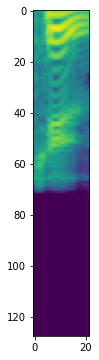

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
1.0701715146333348
TEST
loss: 1.4133933856923093
accuracy: 0.6709677419354839
******************
epoch: 1
Train
0.5343285901095832
TEST
loss: 0.5044556152436042
accuracy: 0.8365591397849462
******************
epoch: 2
Train
0.36591764490130646
TEST
loss: 0.2619766745836504
accuracy: 0.9161290322580645
******************
epoch: 3
Train
0.3562019515178765
TEST
loss: 0.2269675520158583
accuracy: 0.9139784946236559
******************
epoch: 4
Train
0.29530714109628253
TEST
loss: 0.6798466705506848
accuracy: 0.810752688172043
******************
epoch: 5
Train
0.21959225545342917
TEST
loss: 1.318216339747111
accuracy: 0.7376344086021506
******************
epoch: 6
Train
0.24303752527355058
TEST
loss: 0.344689746809903
accuracy: 0.9053763440860215
******************
epoch: 7
Train
0.2960582736941776
TEST
loss: 0.19259579024648155
accuracy: 0.9419354838709677
******************
epoch: 8
Train
0.15206734142198508
TEST
loss: 0.170521153173139
accuracy: 0.9483870967741935
*********

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


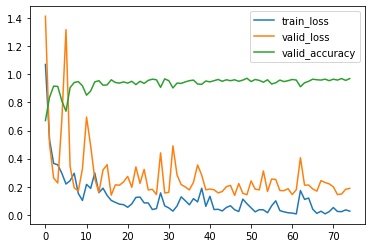

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2581716754709962
TEST
loss: 1.1119826437324607
accuracy: 0.7139784946236559
******************
epoch: 1
Train
0.5127234809425613
TEST
loss: 0.4130753367177902
accuracy: 0.8817204301075269
******************
epoch: 2
Train
0.4108258713684739
TEST
loss: 1.3251052061716715
accuracy: 0.7354838709677419
******************
epoch: 3
Train
0.3420989698277537
TEST
loss: 0.3632991533125601
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.33082441039539884
TEST
loss: 0.63596352787428
accuracy: 0.8344086021505376
******************
epoch: 5
Train
0.3515042528774896
TEST
loss: 0.2942435799747385
accuracy: 0.9118279569892473
******************
epoch: 6
Train
0.3676624681979145
TEST
loss: 0.367534287001497
accuracy: 0.9010752688172043
******************
epoch: 7
Train
0.27720981653364485
TEST
loss: 0.34585979231583175
accuracy: 0.9075268817204301
******************
epoch: 8
Train
0.19731136381337253
TEST
loss: 0.3294545505636482
accuracy: 

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


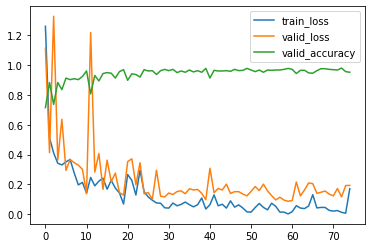

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2601913378709866
TEST
loss: 1.4352112062515752
accuracy: 0.6731182795698925
******************
epoch: 1
Train
0.5249221279984465
TEST
loss: 0.40431610550931707
accuracy: 0.8817204301075269
******************
epoch: 2
Train
0.4769671800384357
TEST
loss: 0.2951826980677984
accuracy: 0.9204301075268817
******************
epoch: 3
Train
0.3817774698691915
TEST
loss: 0.4348984981095919
accuracy: 0.8709677419354839
******************
epoch: 4
Train
0.33780597330872963
TEST
loss: 0.21774599721995733
accuracy: 0.9311827956989247
******************
epoch: 5
Train
0.34220899403191535
TEST
loss: 0.6400900844604739
accuracy: 0.8408602150537634
******************
epoch: 6
Train
0.3049238468924067
TEST
loss: 0.27751480385821353
accuracy: 0.9182795698924732
******************
epoch: 7
Train
0.24192517048964657
TEST
loss: 0.20959700615175308
accuracy: 0.9419354838709677
******************
epoch: 8
Train
0.221925840656412
TEST
loss: 0.25560678730728803
accu

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


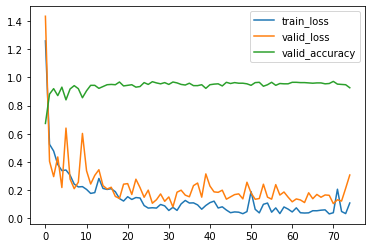

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.1602402448525786
TEST
loss: 1.685868049949728
accuracy: 0.621505376344086
******************
epoch: 1
Train
0.45680982949724747
TEST
loss: 0.5720653160925835
accuracy: 0.8365591397849462
******************
epoch: 2
Train
0.3989223793237262
TEST
loss: 0.8115731968674609
accuracy: 0.8236559139784946
******************
epoch: 3
Train
0.34706303851220577
TEST
loss: 0.47361455502048616
accuracy: 0.8602150537634409
******************
epoch: 4
Train
0.29250340610662323
TEST
loss: 0.3107526672783718
accuracy: 0.9032258064516129
******************
epoch: 5
Train
0.2729720210091812
TEST
loss: 0.5651197120707522
accuracy: 0.8623655913978494
******************
epoch: 6
Train
0.2628670949358483
TEST
loss: 0.3188991165930225
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.1483697509919692
TEST
loss: 0.16884546484998478
accuracy: 0.9591397849462365
******************
epoch: 8
Train
0.20079090467498195
TEST
loss: 0.308703738515095
accuracy

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


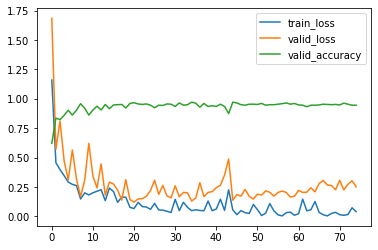

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2452316606436356
TEST
loss: 0.6156284172047851
accuracy: 0.8064516129032258
******************
epoch: 1
Train
0.5095375819301246
TEST
loss: 0.5566686291848459
accuracy: 0.8279569892473119
******************
epoch: 2
Train
0.43167232273083317
TEST
loss: 0.9865528621981221
accuracy: 0.6924731182795699
******************
epoch: 3
Train
0.2823868584234867
TEST
loss: 0.2794631290820337
accuracy: 0.9139784946236559
******************
epoch: 4
Train
0.3033612020951673
TEST
loss: 0.6364977367462651
accuracy: 0.8494623655913979
******************
epoch: 5
Train
0.27384887071598196
TEST
loss: 0.19964404541959044
accuracy: 0.9333333333333333
******************
epoch: 6
Train
0.17078800737761526
TEST
loss: 1.0637416490944482
accuracy: 0.7569892473118279
******************
epoch: 7
Train
0.22438474350163035
TEST
loss: 0.37627587203056584
accuracy: 0.9010752688172043
******************
epoch: 8
Train
0.15792823501139897
TEST
loss: 0.600230735219935
accur

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


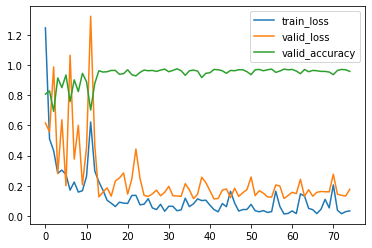

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.1819208586286587
TEST
loss: 1.1553337099731609
accuracy: 0.6860215053763441
******************
epoch: 1
Train
0.5651646823605736
TEST
loss: 0.5240449813104445
accuracy: 0.8451612903225807
******************
epoch: 2
Train
0.48284936426272623
TEST
loss: 0.3226571650274338
accuracy: 0.8903225806451613
******************
epoch: 3
Train
0.3881486191438871
TEST
loss: 0.6867808538098489
accuracy: 0.843010752688172
******************
epoch: 4
Train
0.3814846779880308
TEST
loss: 0.36795403047274516
accuracy: 0.886021505376344
******************
epoch: 5
Train
0.30881556831641294
TEST
loss: 0.7272940810008716
accuracy: 0.8172043010752689
******************
epoch: 6
Train
0.28114043857438886
TEST
loss: 0.33493640422821047
accuracy: 0.9139784946236559
******************
epoch: 7
Train
0.28049394063045724
TEST
loss: 0.28118358613342365
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.32013148520749685
TEST
loss: 0.39167246382723575
accu

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


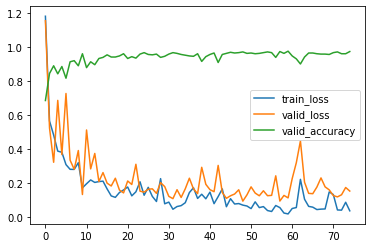

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
2.1907647726801565
TEST
loss: 2.0897313184635613
accuracy: 0.3333333333333333
******************
epoch: 1
Train
1.7044085489528822
TEST
loss: 1.1544640328294486
accuracy: 0.5956989247311828
******************
epoch: 2
Train
1.4868737535574261
TEST
loss: 1.0584534209261658
accuracy: 0.6860215053763441
******************
epoch: 3
Train
1.2851466945120258
TEST
loss: 0.8130944482741818
accuracy: 0.7569892473118279
******************
epoch: 4
Train
1.211307632454506
TEST
loss: 0.5968493045017284
accuracy: 0.8043010752688172
******************
epoch: 5
Train
1.088373678758957
TEST
loss: 0.7960422091586615
accuracy: 0.7462365591397849
******************
epoch: 6
Train
1.168753374662846
TEST
loss: 0.7571652131695901
accuracy: 0.7720430107526882
******************
epoch: 7
Train
1.0333071459861103
TEST
loss: 0.9687670779484574
accuracy: 0.7677419354838709
******************
epoch: 8
Train
1.050358024343054
TEST
loss: 0.7261121565295804
accuracy: 0.772

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


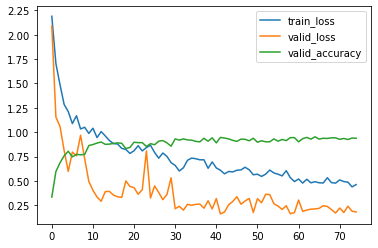

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.685716480610508
TEST
loss: 2.2477077591803765
accuracy: 0.35698924731182796
******************
epoch: 1
Train
0.8484478990557891
TEST
loss: 1.133231088935688
accuracy: 0.6602150537634408
******************
epoch: 2
Train
0.656138472744516
TEST
loss: 1.026414103918178
accuracy: 0.6709677419354839
******************
epoch: 3
Train
0.5938481886539655
TEST
loss: 2.39458887961603
accuracy: 0.5741935483870968
******************
epoch: 4
Train
0.458022100153827
TEST
loss: 2.3016787026518135
accuracy: 0.421505376344086
******************
epoch: 5
Train
0.3940169725228075
TEST
loss: 0.8582991851273404
accuracy: 0.7118279569892473
******************
epoch: 6
Train
0.39018860887826357
TEST
loss: 0.5832224651049542
accuracy: 0.8086021505376344
******************
epoch: 7
Train
0.37146471313205404
TEST
loss: 1.555505576697729
accuracy: 0.6129032258064516
******************
epoch: 8
Train
0.4288710451890014
TEST
loss: 1.4151886301655923
accuracy: 0.61505

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


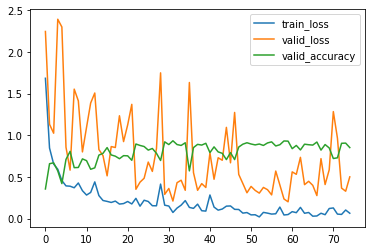

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2557594637493326
TEST
loss: 1.0699652220613214
accuracy: 0.7741935483870968
******************
epoch: 1
Train
0.49048082418960465
TEST
loss: 0.3568120024537527
accuracy: 0.9118279569892473
******************
epoch: 2
Train
0.3594608142225731
TEST
loss: 1.2073011157333209
accuracy: 0.7139784946236559
******************
epoch: 3
Train
0.3607778667312318
TEST
loss: 0.6037804690740441
accuracy: 0.8258064516129032
******************
epoch: 4
Train
0.3570755612933642
TEST
loss: 0.5318505275634027
accuracy: 0.8516129032258064
******************
epoch: 5
Train
0.2817709192384875
TEST
loss: 0.33540368176275687
accuracy: 0.9032258064516129
******************
epoch: 6
Train
0.25635773550135255
TEST
loss: 0.3883335175052766
accuracy: 0.8881720430107527
******************
epoch: 7
Train
0.23730403720915286
TEST
loss: 0.31243103774645
accuracy: 0.9139784946236559
******************
epoch: 8
Train
0.19376328248905764
TEST
loss: 0.2748445012236154
accuracy

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


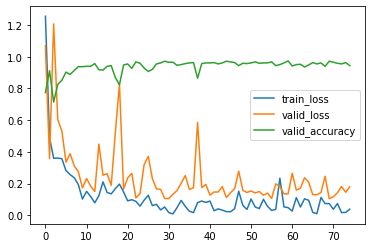

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.1723164038177967
TEST
loss: 1.0493033232227449
accuracy: 0.7634408602150538
******************
epoch: 1
Train
0.4890189737033382
TEST
loss: 0.6908676751198307
accuracy: 0.7978494623655914
******************
epoch: 2
Train
0.3730155358599538
TEST
loss: 0.657770481160892
accuracy: 0.789247311827957
******************
epoch: 3
Train
0.37204426555910863
TEST
loss: 0.5666829404651478
accuracy: 0.8451612903225807
******************
epoch: 4
Train
0.25896897711417466
TEST
loss: 0.23619919707698206
accuracy: 0.9397849462365592
******************
epoch: 5
Train
0.24043505546156924
TEST
loss: 0.2890446439866097
accuracy: 0.9204301075268817
******************
epoch: 6
Train
0.1951272900070339
TEST
loss: 0.39786954002995645
accuracy: 0.8946236559139785
******************
epoch: 7
Train
0.20253159412306743
TEST
loss: 0.16388772610695132
accuracy: 0.9548387096774194
******************
epoch: 8
Train
0.21590377164901298
TEST
loss: 0.3017245061295007
accur

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


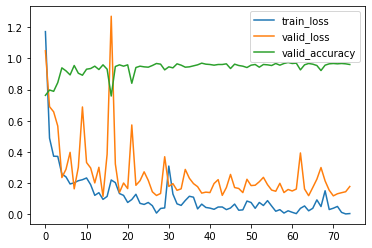

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2817370397272967
TEST
loss: 0.9306727787499787
accuracy: 0.7440860215053764
******************
epoch: 1
Train
0.6341749400815209
TEST
loss: 0.3354438352328475
accuracy: 0.8817204301075269
******************
epoch: 2
Train
0.40996442601189026
TEST
loss: 0.4084975646388146
accuracy: 0.886021505376344
******************
epoch: 3
Train
0.4219342879088386
TEST
loss: 0.6219363145930793
accuracy: 0.8236559139784946
******************
epoch: 4
Train
0.3766037765599478
TEST
loss: 0.6950946530988139
accuracy: 0.853763440860215
******************
epoch: 5
Train
0.36114037710938585
TEST
loss: 0.5889678837150656
accuracy: 0.7849462365591398
******************
epoch: 6
Train
0.32898329802591697
TEST
loss: 0.5518740230350084
accuracy: 0.832258064516129
******************
epoch: 7
Train
0.35373699889750526
TEST
loss: 0.225452608190557
accuracy: 0.9139784946236559
******************
epoch: 8
Train
0.24021273834342974
TEST
loss: 0.3308194798167034
accuracy: 

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


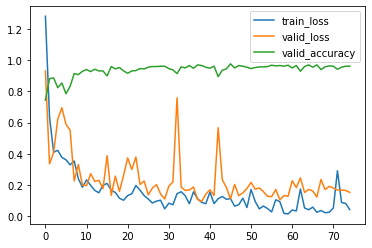

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
2.0665381615946354
TEST
loss: 1.8002451578776042
accuracy: 0.5118279569892473
******************
epoch: 1
Train
1.5946517519624759
TEST
loss: 1.0065092094482915
accuracy: 0.6666666666666666
******************
epoch: 2
Train
1.3879074984875557
TEST
loss: 0.9110552013561289
accuracy: 0.7096774193548387
******************
epoch: 3
Train
1.23805867669142
TEST
loss: 1.0582180607703424
accuracy: 0.6752688172043011
******************
epoch: 4
Train
1.2034205641872342
TEST
loss: 0.7261858181286883
accuracy: 0.7655913978494624
******************
epoch: 5
Train
1.1142534412359382
TEST
loss: 0.49772050008978896
accuracy: 0.8064516129032258
******************
epoch: 6
Train
1.076302783233733
TEST
loss: 0.7076550936186186
accuracy: 0.7483870967741936
******************
epoch: 7
Train
1.0588671317585836
TEST
loss: 0.4842279531622446
accuracy: 0.8387096774193549
******************
epoch: 8
Train
0.9932865929510495
TEST
loss: 0.39764063691580165
accuracy: 0.

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


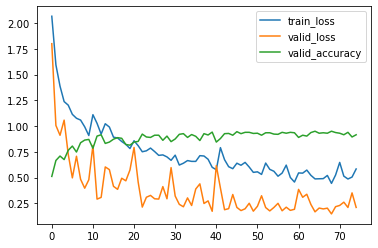

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.1162718933117795
TEST
loss: 0.902242471069418
accuracy: 0.7612903225806451
******************
epoch: 1
Train
0.5407210304715265
TEST
loss: 0.6074070033206734
accuracy: 0.8387096774193549
******************
epoch: 2
Train
0.4269138443001381
TEST
loss: 0.23896914156534338
accuracy: 0.9247311827956989
******************
epoch: 3
Train
0.34976087055606875
TEST
loss: 0.2677659769212046
accuracy: 0.9096774193548387
******************
epoch: 4
Train
0.3463121979353437
TEST
loss: 0.715800456846914
accuracy: 0.8150537634408602
******************
epoch: 5
Train
0.32028987918672985
TEST
loss: 0.3543863992537222
accuracy: 0.8795698924731182
******************
epoch: 6
Train
0.23036606284836383
TEST
loss: 0.14660207776613132
accuracy: 0.9548387096774194
******************
epoch: 7
Train
0.25813364661632204
TEST
loss: 0.6211003821383241
accuracy: 0.8365591397849462
******************
epoch: 8
Train
0.28388379094144256
TEST
loss: 0.304755691687266
accurac

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


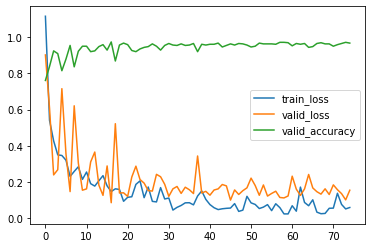

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
2.111436496194358
TEST
loss: 2.3913650399895126
accuracy: 0.3763440860215054
******************
epoch: 1
Train
1.493058230328701
TEST
loss: 0.8633122187788769
accuracy: 0.7139784946236559
******************
epoch: 2
Train
1.3485302937948775
TEST
loss: 1.0107773260403705
accuracy: 0.7053763440860215
******************
epoch: 3
Train
1.1751805444397976
TEST
loss: 0.9275827710346509
accuracy: 0.7741935483870968
******************
epoch: 4
Train
1.1315975700839591
TEST
loss: 0.4923961243321819
accuracy: 0.8580645161290322
******************
epoch: 5
Train
1.0640741488467511
TEST
loss: 0.592120324796246
accuracy: 0.8064516129032258
******************
epoch: 6
Train
1.1034679701717296
TEST
loss: 0.593123286642054
accuracy: 0.7913978494623656
******************
epoch: 7
Train
1.0129500239140639
TEST
loss: 0.6598969933807209
accuracy: 0.8021505376344086
******************
epoch: 8
Train
1.0264926175789995
TEST
loss: 0.31901566527223074
accuracy: 0.90

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


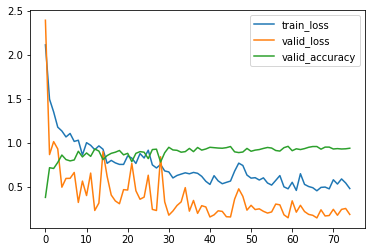

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.215434795948659
TEST
loss: 0.672644050980127
accuracy: 0.8064516129032258
******************
epoch: 1
Train
0.6453068550389238
TEST
loss: 0.3672759147100551
accuracy: 0.8903225806451613
******************
epoch: 2
Train
0.3665282660809395
TEST
loss: 0.24586936382837193
accuracy: 0.9268817204301075
******************
epoch: 3
Train
0.32580896263553943
TEST
loss: 0.5133510190953491
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.27825178439474646
TEST
loss: 0.46427819030259243
accuracy: 0.886021505376344
******************
epoch: 5
Train
0.23941093392762433
TEST
loss: 0.8589207441576066
accuracy: 0.7548387096774194
******************
epoch: 6
Train
0.26290608193839693
TEST
loss: 0.2788447686420974
accuracy: 0.9268817204301075
******************
epoch: 7
Train
0.27230896253899084
TEST
loss: 0.22040253570002893
accuracy: 0.9376344086021505
******************
epoch: 8
Train
0.15036333101467061
TEST
loss: 0.33060888013532086
accu

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


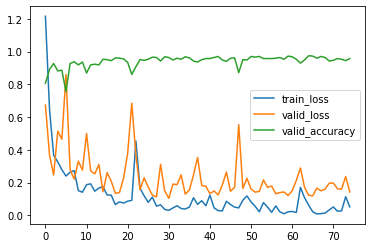

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2826706380951962
TEST
loss: 0.9645720330617761
accuracy: 0.7978494623655914
******************
epoch: 1
Train
0.6423496274326717
TEST
loss: 0.7828643994946634
accuracy: 0.8
******************
epoch: 2
Train
0.4521465858722414
TEST
loss: 0.48195004527286817
accuracy: 0.8473118279569892
******************
epoch: 3
Train
0.4226917489985978
TEST
loss: 0.31339266864202353
accuracy: 0.9032258064516129
******************
epoch: 4
Train
0.4141784190618035
TEST
loss: 0.3673295658121827
accuracy: 0.8924731182795699
******************
epoch: 5
Train
0.32190826424489305
TEST
loss: 0.8036932103095517
accuracy: 0.8150537634408602
******************
epoch: 6
Train
0.27815878975436326
TEST
loss: 0.7269488887120319
accuracy: 0.8236559139784946
******************
epoch: 7
Train
0.30202616249674036
TEST
loss: 0.30102912995123093
accuracy: 0.9053763440860215
******************
epoch: 8
Train
0.2270637810401775
TEST
loss: 0.6559701558082335
accuracy: 0.81505376

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


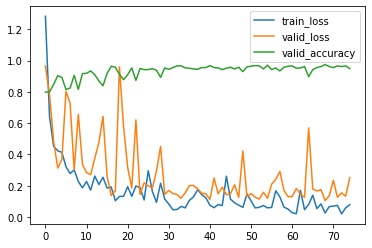

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2866459659305258
TEST
loss: 0.6705126940563161
accuracy: 0.821505376344086
******************
epoch: 1
Train
0.5283042290676776
TEST
loss: 0.7646014052052652
accuracy: 0.7978494623655914
******************
epoch: 2
Train
0.4268530846669203
TEST
loss: 0.3144635604273888
accuracy: 0.8903225806451613
******************
epoch: 3
Train
0.31094825851962204
TEST
loss: 0.36145057473131403
accuracy: 0.8774193548387097
******************
epoch: 4
Train
0.34765456540647477
TEST
loss: 0.47524323463439944
accuracy: 0.8623655913978494
******************
epoch: 5
Train
0.22746019659982167
TEST
loss: 0.44945926538077735
accuracy: 0.864516129032258
******************
epoch: 6
Train
0.21553787905231367
TEST
loss: 0.28505471960831713
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.28212466340072706
TEST
loss: 0.3441275935019216
accuracy: 0.8795698924731182
******************
epoch: 8
Train
0.24940316456705572
TEST
loss: 0.39861996378949893
ac

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


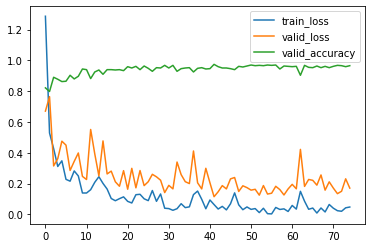

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.209894819739819
TEST
loss: 1.2259380555921986
accuracy: 0.7118279569892473
******************
epoch: 1
Train
0.6590493440499663
TEST
loss: 0.5145241052873673
accuracy: 0.8623655913978494
******************
epoch: 2
Train
0.4648957569623546
TEST
loss: 0.33781167819935787
accuracy: 0.9010752688172043
******************
epoch: 3
Train
0.3825380953653692
TEST
loss: 0.37254582182053597
accuracy: 0.896774193548387
******************
epoch: 4
Train
0.3722421144630296
TEST
loss: 0.45814855970362184
accuracy: 0.8709677419354839
******************
epoch: 5
Train
0.2603456425808037
TEST
loss: 0.4467476888369488
accuracy: 0.875268817204301
******************
epoch: 6
Train
0.267045669261653
TEST
loss: 0.3956835457073745
accuracy: 0.9010752688172043
******************
epoch: 7
Train
0.25498410667792787
TEST
loss: 0.3681636489847655
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.2339060488159482
TEST
loss: 0.7421801315840855
accuracy: 0.

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


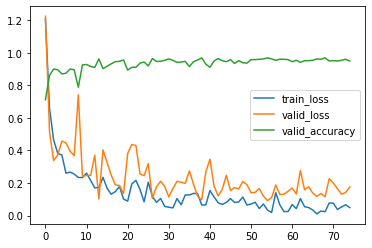

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.2278361801954771
TEST
loss: 0.9530611820118402
accuracy: 0.7505376344086021
******************
epoch: 1
Train
0.6125732870209776
TEST
loss: 0.428870165348053
accuracy: 0.8666666666666667
******************
epoch: 2
Train
0.4175058083952789
TEST
loss: 0.5170219177840858
accuracy: 0.8580645161290322
******************
epoch: 3
Train
0.3527145512847407
TEST
loss: 0.5066054541577575
accuracy: 0.8838709677419355
******************
epoch: 4
Train
0.34303867752730494
TEST
loss: 0.34361679271985124
accuracy: 0.8903225806451613
******************
epoch: 5
Train
0.2956392331089971
TEST
loss: 0.5239280777592813
accuracy: 0.8709677419354839
******************
epoch: 6
Train
0.2754423461681935
TEST
loss: 0.3727401081592806
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.26683165539832415
TEST
loss: 0.26460443139076234
accuracy: 0.9225806451612903
******************
epoch: 8
Train
0.17103115473831285
TEST
loss: 0.2198705707826922
accurac

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


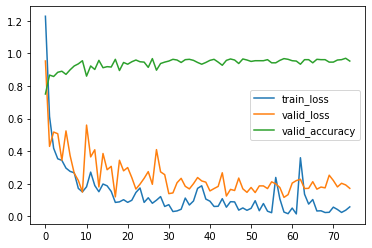

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.4726975739612076
TEST
loss: 0.9732896484354491
accuracy: 0.7053763440860215
******************
epoch: 1
Train
0.7378885495643431
TEST
loss: 0.3623113613615754
accuracy: 0.875268817204301
******************
epoch: 2
Train
0.5568316228041805
TEST
loss: 0.34119106928507487
accuracy: 0.8946236559139785
******************
epoch: 3
Train
0.44311189285580294
TEST
loss: 0.2852063652007811
accuracy: 0.9010752688172043
******************
epoch: 4
Train
0.3696074237987824
TEST
loss: 0.770953401442497
accuracy: 0.864516129032258
******************
epoch: 5
Train
0.44915994072576715
TEST
loss: 0.20491486973659967
accuracy: 0.9376344086021505
******************
epoch: 6
Train
0.3159129265886388
TEST
loss: 0.3167410009650774
accuracy: 0.9096774193548387
******************
epoch: 7
Train
0.43752903763684264
TEST
loss: 0.40718973503317885
accuracy: 0.8924731182795699
******************
epoch: 8
Train
0.26857429655949855
TEST
loss: 0.19698485578260114
accura

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


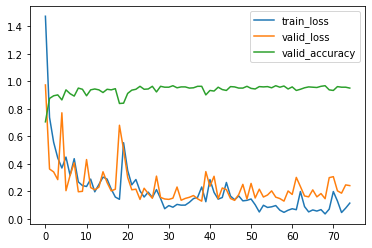

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()